In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re
from IPython.display import clear_output

In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if record.shape!=(2,2,5):
        raise ValueError('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [13]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [14]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [15]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 5)
(99, 10)


# parameters calculation functions

In [16]:
## DONT USE VVV
def get_order_inbalance_interval_bad(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        for j in range(interval):
            #print(np.sum(record[i:i+interval,0,1]))
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result
###DONT USE AAAA

def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [17]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[1504.,  466., 2115., 8682.,  667.],
       [3396.,  701., 2615., 8682.,  501.],
       [3582.,  701., 2115., 8682., 1001.],
       [3323., 3262., 3146., 9713., 2032.]])

In [18]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [20]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [21]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [22]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [23]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [24]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [25]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [26]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [27]:
1e7

10000000.0

# HEATMAP

In [28]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


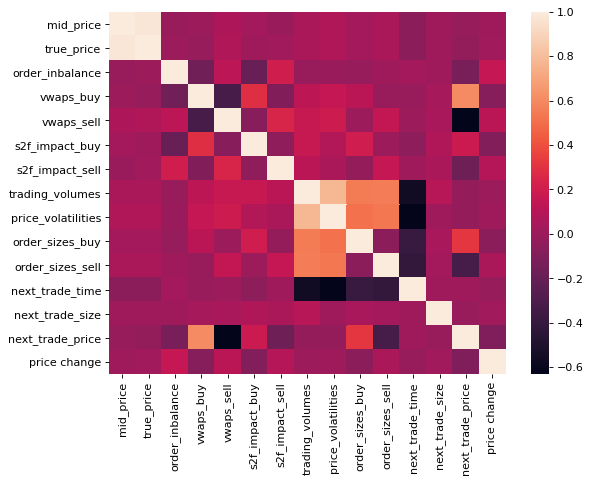

In [29]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [30]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [31]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [32]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [33]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [34]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [35]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [36]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [37]:
'''
TODO
        #USE REGEX TO CHECK IF STATEMENT
        elif name in ['vwaps_buy', 's2f_impact_buy',   
                      'vwaps_sell', 's2f_impact_sell', 
                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',
                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
'''

"\nTODO\n        #USE REGEX TO CHECK IF STATEMENT\n        elif name in ['vwaps_buy', 's2f_impact_buy',   \n                      'vwaps_sell', 's2f_impact_sell', \n                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',\n                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:\n"

In [38]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [39]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [40]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [41]:
def logistic_regr_cross_val(X_train, y_train, X_test, y_test, 
                               use_scaling=True, 
                               local_names=names,
                               track_params=False):
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X_train, y_train)
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [42]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [43]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [44]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [45]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
decision_tree
Coefficient impact:
order_inbalance   0.18069727532057314
vwaps_buy   0.07347567246133037
vwaps_sell   0.04897213668002377
s2f_impact_buy   0.03925212692967271
s2f_impact_sell   0.0325384996334222
trading_volumes   0.06304642000072377
price_volatilities   0.01642309371665008
vwaps_order_sizes_buy   0.014209815386705545
vwaps_order_sizes_sell   0.035329828081254615
s2f_order_sizes_buy   0.055473745628866845
s2f_order_sizes_sell   0.0273328743065737
next_trade_time   0.10027299276310923
next_trade_size   0.14757193861257356
next_trade_price   0.1654035804785206
score:  0.5263157894736842
log reg
Coefficient impact:
order_inbalance   -0.7062669469926882
vwaps_buy   -1.0035278915244832
vwaps_sell   1.347472003494649
s2f_impact_buy   -0.06193011754906547
s2f_impact_sell   0.23461187211592183
trading_volumes   0.20590750194726634
price_volatilities   -0.3065772153289346
vwaps_order_sizes_buy   0.02539491263371483
vwaps_order_sizes_sell   0.6518797542006699
s2f

In [81]:
def xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X_train, y_train)
    else:
        clf = xgb.XGBClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [82]:
def cross_validation(X, y, model, num_of_day = 10, use_scaling = True):
    num_of_samples_in_day = X.shape[0]//num_of_day
    plot_indicators = np.zeros(shape = (10, 3))
    for day in range(num_of_day):
        try:
            X_train = np.concatenate((X[:day*num_of_samples_in_day], X[(day+1)*num_of_samples_in_day:]))
            y_train = np.concatenate((y[:day*num_of_samples_in_day], y[(day+1)*num_of_samples_in_day:]))
            X_test = X[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            y_test = y[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            if model == 'log_reg':
                score, precision, recall = logistic_regr_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling, local_names=names,track_params=False)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'xgb':
                score, precision, recall = xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
        except ValueError as err:
            plot_indicators[day][0] = math.nan
            plot_indicators[day][1] = math.nan
            plot_indicators[day][2] = math.nan
            print(err)
    return plot_indicators

# Testy modeli na wybranym thresholdzie i porównanie

In [47]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

### Logistic regression

#### Bez skalowania

Przyklad 1

In [48]:
comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X = get_X(comp_id, interval, time_to_skip, time_back, names)
y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
#X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
Coefficient impact:
order_inbalance   2.2670055297665657e-07
vwaps_buy   2.2422046924630513e-06
vwaps_sell   7.1669859467916774e-06
s2f_impact_buy   6.765772092271363e-07
s2f_impact_sell   1.061609551462548e-06
trading_volumes   -0.00015139091296873208
price_volatilities   -9.657333994503926e-08
vwaps_order_sizes_buy   0.0001361818404483448
vwaps_order_sizes_sell   0.00015971152661422653
s2f_order_sizes_buy   9.457530448788974e-05
s2f_order_sizes_sell   4.9239356268652594e-05
next_trade_time   9.736030926077503e-05
next_trade_size   0.0005263568168857053
next_trade_price   -4.842780482244597e-06
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 104
Number of negative class in testing dataset = 51
Percent of correct classification:
0.7161290322580646
Confusion matrix:
[[104   0]
 [ 44   7]]
Precision:
1.0
Recall:
0.7027027027027027
Coefficient impact:
order_inbalance   2.

Przyklad 2

In [49]:
comp_id = 7
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X = get_X(comp_id, interval, time_to_skip, time_back, names)
y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
#X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
Coefficient impact:
order_inbalance   -1.4099418058536497e-08
vwaps_buy   1.3963623302725177e-07
vwaps_sell   1.7511198175808276e-07
s2f_impact_buy   -2.216842087996057e-09
s2f_impact_sell   -1.2688406739331389e-08
trading_volumes   -5.096933560364703e-05
price_volatilities   1.5818639339798153e-07
vwaps_order_sizes_buy   4.5019097559422675e-05
vwaps_order_sizes_sell   5.665903846922285e-05
s2f_order_sizes_buy   8.67814909245832e-06
s2f_order_sizes_sell   3.336055922710732e-05
next_trade_time   -1.207768641290915e-06
next_trade_size   4.667616525982503e-05
next_trade_price   -2.6014610359210467e-08
Number of positive class in training dataset = 762
Number of negative class in training dataset = 633
Number of positive class in testing dataset = 113
Number of negative class in testing dataset = 42
Percent of correct classification:
0.6967741935483871
Confusion matrix:
[[99 14]
 [33  9]]
Precision:
0.8761061946902655
Recall:
0.75
Coefficient impact:
order_inbalance   1.

Coefficient impact:
order_inbalance   -5.588472763288516e-09
vwaps_buy   2.0861157411449792e-07
vwaps_sell   1.6928676587496168e-07
s2f_impact_buy   -1.5736539530216647e-10
s2f_impact_sell   -1.113616512370514e-08
trading_volumes   -5.1431080201343826e-05
price_volatilities   1.1306927136336873e-07
vwaps_order_sizes_buy   4.4439971186471466e-05
vwaps_order_sizes_sell   5.5173151739732116e-05
s2f_order_sizes_buy   2.428280622891867e-05
s2f_order_sizes_sell   3.0063001862468757e-05
next_trade_time   -4.1559339605908694e-08
next_trade_size   4.626114739031993e-05
next_trade_price   5.0797259683068566e-08
Number of positive class in training dataset = 793
Number of negative class in training dataset = 602
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 73
Percent of correct classification:
0.535483870967742
Confusion matrix:
[[77  5]
 [67  6]]
Precision:
0.9390243902439024
Recall:
0.5347222222222222
Average model accuracy: 0.516774193548387
Av

Mean of all companies for max

In [50]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -3.994784093735728e-07
vwaps_buy   7.098647681309484e-06
vwaps_sell   4.053749070971804e-06
s2f_impact_buy   -5.508299401910682e-07
s2f_impact_sell   5.332084911474661e-07
trading_volumes   -0.0014226359277972618
price_volatilities   -1.2911998192704714e-07
vwaps_order_sizes_buy   0.0015304625937405962
vwaps_order_sizes_sell   0.0014245203380922821
s2f_order_sizes_buy   -1.6165670862336405e-05
s2f_order_sizes_sell   0.0002052790360586519
next_trade_time   -6.30826329529386e-05
next_trade_size   0.00015657431662303043
next_trade_price   2.4979328533914583e-06
Number of positive class in training dataset = 843
Number of negative class in training dataset = 552
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.6516129032258065
Confusion matrix:
[[92  0]
 [54  9]]
Precision:
1.0
Recall:
0.6301369863013698
Coefficient impact:
order_inbalance   -5.1447786065

Coefficient impact:
order_inbalance   -4.1706341300244273e-07
vwaps_buy   7.377691289455924e-07
vwaps_sell   3.4024059677086917e-06
s2f_impact_buy   1.0351628705810634e-07
s2f_impact_sell   -1.9835420857593774e-07
trading_volumes   -0.0013065335478801726
price_volatilities   -1.695361850071916e-07
vwaps_order_sizes_buy   0.0014361264814370873
vwaps_order_sizes_sell   0.0013473404949122076
s2f_order_sizes_buy   -4.0368966033716736e-05
s2f_order_sizes_sell   0.00014750910538653515
next_trade_time   -5.5579156997058865e-05
next_trade_size   -8.205636363199289e-05
next_trade_price   -2.785930937679051e-06
Number of positive class in training dataset = 834
Number of negative class in training dataset = 561
Number of positive class in testing dataset = 101
Number of negative class in testing dataset = 54
Percent of correct classification:
0.7032258064516129
Confusion matrix:
[[101   0]
 [ 46   8]]
Precision:
1.0
Recall:
0.6870748299319728


In [51]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.6033365917236887
Average precision with scaling: 0.8679321471897529
Average recall with scaling: 0.6211568510673052


Mean of all companies for min

In [52]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -1.8828591217146127e-06
vwaps_buy   7.750098784825253e-05
vwaps_sell   1.9195794835002095e-05
s2f_impact_buy   1.630705180952474e-05
s2f_impact_sell   5.566725081827462e-06
trading_volumes   -0.0002970850321358251
price_volatilities   -3.7289466459989946e-09
vwaps_order_sizes_buy   0.0001613053463385081
vwaps_order_sizes_sell   0.00016423986753041068
s2f_order_sizes_buy   5.2840451793058134e-05
s2f_order_sizes_sell   8.961440309866106e-05
next_trade_time   0.0009360994605470765
next_trade_size   0.002625491109233562
next_trade_price   5.851931052256638e-05
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 67
Percent of correct classification:
0.5483870967741935
Confusion matrix:
[[81  7]
 [63  4]]
Precision:
0.9204545454545454
Recall:
0.5625
Coefficient impact:
order_inbalance   -2.416742560

In [53]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.576454871293581
Average precision with scaling: 0.8199232778923681
Average recall with scaling: nan


#### Ze skalowaniem

Przyklad 1

In [59]:
comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X = get_X(comp_id, interval, time_to_skip, time_back, names)
y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
#X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
Coefficient impact:
order_inbalance   0.4890604970328552
vwaps_buy   0.44939581313920995
vwaps_sell   0.8326933838588187
s2f_impact_buy   0.8222000195703376
s2f_impact_sell   1.0130464399879642
trading_volumes   -1.6802226300167704
price_volatilities   0.5267784922843417
vwaps_order_sizes_buy   -0.8113233323001273
vwaps_order_sizes_sell   0.7891015577624829
s2f_order_sizes_buy   -0.347581718396614
s2f_order_sizes_sell   -1.2280689273486873
next_trade_time   1.028525295521642
next_trade_size   0.46890008360939794
next_trade_price   -0.0060772297661219245
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 104
Number of negative class in testing dataset = 51
Percent of correct classification:
0.6387096774193548
Confusion matrix:
[[96  8]
 [48  3]]
Precision:
0.9230769230769231
Recall:
0.6666666666666666
Coefficient impact:
order_inbalance   0.5181524465217651
vwaps_buy   0.3

Przyklad 2

In [54]:
comp_id = 7
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X = get_X(comp_id, interval, time_to_skip, time_back, names)
y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
#X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
Coefficient impact:
order_inbalance   -0.2541731541047534
vwaps_buy   0.551566111973438
vwaps_sell   1.6822625608017596
s2f_impact_buy   -0.1379636929640886
s2f_impact_sell   -1.1808795539449917
trading_volumes   -1.9620348176411044
price_volatilities   0.2325294995916844
vwaps_order_sizes_buy   -0.33917109148997976
vwaps_order_sizes_sell   0.6224633839331417
s2f_order_sizes_buy   -0.6248050935216554
s2f_order_sizes_sell   0.506623883792839
next_trade_time   -1.9043734260775722
next_trade_size   1.0364394102607772
next_trade_price   -0.27897693650868083
Number of positive class in training dataset = 762
Number of negative class in training dataset = 633
Number of positive class in testing dataset = 113
Number of negative class in testing dataset = 42
Percent of correct classification:
0.7225806451612903
Confusion matrix:
[[105   8]
 [ 35   7]]
Precision:
0.9292035398230089
Recall:
0.75
Coefficient impact:
order_inbalance   0.11990174766141067
vwaps_buy   0.3409962768

Mean on all companies for max

In [55]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.3379242990737714
vwaps_buy   0.25465838336692836
vwaps_sell   -0.10517218293644627
s2f_impact_buy   -0.5221934668153186
s2f_impact_sell   0.2547325780293074
trading_volumes   -0.7122622633269972
price_volatilities   -1.2755563161056485
vwaps_order_sizes_buy   1.3521778261952238
vwaps_order_sizes_sell   -0.2156293417813287
s2f_order_sizes_buy   -0.16894265837466044
s2f_order_sizes_sell   0.8374979837029971
next_trade_time   -0.9127677475590381
next_trade_size   -0.06107983022567644
next_trade_price   0.14591477390769467
Number of positive class in training dataset = 843
Number of negative class in training dataset = 552
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[83  9]
 [51 12]]
Precision:
0.9021739130434783
Recall:
0.6194029850746269
Coefficient impact:
order_inbalance   -0.32439660210710586
vwaps_buy   -0

In [56]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5811404366243078
Average precision with scaling: 0.8092263291885733
Average recall with scaling: 0.6135316805377142


Mean of all companies for min

In [57]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.5468525348671358
vwaps_buy   0.12704512641815027
vwaps_sell   -0.08421403742747179
s2f_impact_buy   0.23283600119893608
s2f_impact_sell   -0.22549726627482067
trading_volumes   -2.3890803572651307
price_volatilities   0.5738522196498339
vwaps_order_sizes_buy   -1.1383750913470028
vwaps_order_sizes_sell   -0.8856484100541321
s2f_order_sizes_buy   -1.9737851531624724
s2f_order_sizes_sell   -0.3612228222411876
next_trade_time   -0.4215708194887742
next_trade_size   -0.015441517743864187
next_trade_price   0.3900642274328904
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 67
Percent of correct classification:
0.5806451612903226
Confusion matrix:
[[87  1]
 [64  3]]
Precision:
0.9886363636363636
Recall:
0.5761589403973509
Coefficient impact:
order_inbalance   -0.7005528359454797
vwaps_buy   0

In [58]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.569325513196481
Average precision with scaling: 0.7845839444702495
Average recall with scaling: 0.5990654364230847


#### Max z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [66]:
interval=5
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.4672878697448701
vwaps_buy   0.8966301296092031
vwaps_sell   0.7053781609837589
s2f_impact_buy   -0.158235567427125
s2f_impact_sell   1.3374698603103297
trading_volumes   -0.29422272791005477
price_volatilities   0.040952749755408246
vwaps_order_sizes_buy   0.923149286470149
vwaps_order_sizes_sell   -0.05295102281068556
s2f_order_sizes_buy   0.907305276776831
s2f_order_sizes_sell   0.1969168470154856
next_trade_time   1.4344429623588995
next_trade_size   -0.6593222411534223
next_trade_price   0.37232872029311936
Number of positive class in training dataset = 460
Number of negative class in training dataset = 359
Number of positive class in testing dataset = 53
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5384615384615384
Confusion matrix:
[[28 25]
 [17 21]]
Precision:
0.5283018867924528
Recall:
0.6222222222222222
Coefficient impact:
order_inbalance   -0.4947985007410576
vwaps_buy   1.12565319

In [67]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5581529581529584
Average precision with scaling: 0.7156920789483644
Average recall with scaling: nan


#### Max z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [68]:
interval=5
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.7718502384641386
vwaps_buy   0.8638054268524986
vwaps_sell   0.7996202422782887
s2f_impact_buy   -0.0669725088201469
s2f_impact_sell   0.9070450489045362
trading_volumes   0.38075843601030424
price_volatilities   -0.33044422792033407
vwaps_order_sizes_buy   1.2570562745495164
vwaps_order_sizes_sell   0.39537556475833097
s2f_order_sizes_buy   0.13611206404852094
s2f_order_sizes_sell   -0.3153127463790334
next_trade_time   1.6914112897099032
next_trade_size   -0.15693919035615903
next_trade_price   0.22557055422986202
Number of positive class in training dataset = 435
Number of negative class in training dataset = 339
Number of positive class in testing dataset = 48
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5348837209302325
Confusion matrix:
[[23 25]
 [15 23]]
Precision:
0.4791666666666667
Recall:
0.6052631578947368
Coefficient impact:
order_inbalance   -0.8938773690198325
vwaps_buy   1.0530

In [62]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5735259572468874
Average precision with scaling: 0.7610993561275949
Average recall with scaling: nan


#### Min z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [69]:
interval=5
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.3863637129185308
vwaps_buy   -0.3953920051559109
vwaps_sell   -0.8815557654575911
s2f_impact_buy   -0.09646282170842913
s2f_impact_sell   -0.23508125015239809
trading_volumes   -2.4579549776919176
price_volatilities   -0.003568633751534547
vwaps_order_sizes_buy   -0.9535787013953453
vwaps_order_sizes_sell   -1.115020135585456
s2f_order_sizes_buy   -1.0950071139451147
s2f_order_sizes_sell   0.1278159834841371
next_trade_time   -0.05536919477450856
next_trade_size   0.41335132608550146
next_trade_price   0.23133282524481516
Number of positive class in training dataset = 487
Number of negative class in training dataset = 332
Number of positive class in testing dataset = 47
Number of negative class in testing dataset = 44
Percent of correct classification:
0.5164835164835165
Confusion matrix:
[[46  1]
 [43  1]]
Precision:
0.9787234042553191
Recall:
0.5168539325842697
Coefficient impact:
order_inbalance   -0.5588476700860253
vwaps_buy   

In [70]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5399267399267399
Average precision with scaling: 0.6712206892217817
Average recall with scaling: nan


#### Min z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [71]:
interval=5
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -0.119960958511734
vwaps_buy   -0.051257706239803594
vwaps_sell   -0.8255542956573823
s2f_impact_buy   -0.30514933438140374
s2f_impact_sell   0.25520374527736706
trading_volumes   -2.2381125193312963
price_volatilities   -0.05414456978059676
vwaps_order_sizes_buy   -0.4358681052214441
vwaps_order_sizes_sell   -1.4116762899391597
s2f_order_sizes_buy   -0.816207508838169
s2f_order_sizes_sell   0.1870966574572602
next_trade_time   -0.7262775320546416
next_trade_size   0.48859660993298265
next_trade_price   0.3605843190398258
Number of positive class in training dataset = 452
Number of negative class in training dataset = 322
Number of positive class in testing dataset = 47
Number of negative class in testing dataset = 39
Percent of correct classification:
0.5465116279069767
Confusion matrix:
[[47  0]
 [39  0]]
Precision:
1.0
Recall:
0.5465116279069767
Coefficient impact:
order_inbalance   -0.2641870788309541
vwaps_buy   0.2737485796899931

In [72]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5285647169368097
Average precision with scaling: 0.6261866393564482
Average recall with scaling: nan


#### Max z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

In [73]:
interval=5
time_to_skip=30
time_back=30
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -2.6123341387702146
vwaps_buy   2.06927046474056
vwaps_sell   3.4353028989134637
s2f_impact_buy   -0.9490639397214353
s2f_impact_sell   1.864408578960992
trading_volumes   -0.7961945640001656
price_volatilities   -2.2618370881502137
vwaps_order_sizes_buy   -1.2408060195870145
vwaps_order_sizes_sell   0.42290528315951287
s2f_order_sizes_buy   0.30124511536610227
s2f_order_sizes_sell   -0.6261908130907351
next_trade_time   0.024599367223285273
next_trade_size   -0.4793236240746324
next_trade_price   1.6006442005714576
Number of positive class in training dataset = 102
Number of negative class in training dataset = 492
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 50
Percent of correct classification:
0.7575757575757576
Confusion matrix:
[[ 0 16]
 [ 0 50]]
Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   -3.20828239566348
vwaps_buy   1.8857455640975214
vwaps_sell   3.0636654

<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid valu

In [74]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.6944750535659625
Average precision with scaling: nan
Average recall with scaling: nan


#### Max z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005

In [75]:
interval=5
time_to_skip=30
time_back=60
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   -1.9793547496059787
vwaps_buy   0.4220978952088691
vwaps_sell   0.4639352872787656
s2f_impact_buy   -3.5811839194328767
s2f_impact_sell   0.6777484928156183
trading_volumes   0.4232396390942271
price_volatilities   -0.6964738828727357
vwaps_order_sizes_buy   -0.20296750220963553
vwaps_order_sizes_sell   1.0344385411617245
s2f_order_sizes_buy   -0.19723783679386572
s2f_order_sizes_sell   0.9367912958895693
next_trade_time   -0.7640494431503029
next_trade_size   -1.0108544392221273
next_trade_price   1.970720130452098
Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]
Coefficient impact:
order_inbalance   -2.1073138157332116
vwaps_buy   0.4330582056838721
vwaps_sell   0.3990639332191807
s2f_impact_buy   -3.477975926942

<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


In [76]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: nan
Average precision with scaling: nan
Average recall with scaling: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

In [77]:
interval=5
time_to_skip=30
time_back=30
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   2.7940300907250557
vwaps_buy   1.329453353472366
vwaps_sell   0.12652234610724308
s2f_impact_buy   -0.5959122803821979
s2f_impact_sell   -1.3967584891115594
trading_volumes   -0.9481923263891125
price_volatilities   -2.82638753042126
vwaps_order_sizes_buy   0.1594059095245737
vwaps_order_sizes_sell   -1.3663147638783602
s2f_order_sizes_buy   -1.8282730483021774
s2f_order_sizes_sell   -0.48487502108658276
next_trade_time   -1.8320241201983694
next_trade_size   -0.4176346659412485
next_trade_price   0.37979894408419457
Number of positive class in training dataset = 112
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 65
Percent of correct classification:
0.30303030303030304
Confusion matrix:
[[ 1  0]
 [46 19]]
Precision:
1.0
Recall:
0.02127659574468085
Coefficient impact:
order_inbalance   1.9496313465075306
vwaps_buy   1.7446089414778485
vwap

<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid valu

In [78]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: nan
Average precision with scaling: nan
Average recall with scaling: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005

In [79]:
interval=5
time_to_skip=30
time_back=60
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
Coefficient impact:
order_inbalance   2.6840627131930814
vwaps_buy   0.3886506219892076
vwaps_sell   0.06430818807763453
s2f_impact_buy   0.2001345058656266
s2f_impact_sell   1.5175083406073886
trading_volumes   -1.9363698351340493
price_volatilities   -1.5462989629868404
vwaps_order_sizes_buy   -1.0101799769070485
vwaps_order_sizes_sell   -1.537306377408505
s2f_order_sizes_buy   -1.0959467237792333
s2f_order_sizes_sell   -1.851161959382355
next_trade_time   -0.13701677404250423
next_trade_size   -1.3185665761404537
next_trade_price   0.34596704338292483
Number of positive class in training dataset = 46
Number of negative class in training dataset = 278
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 35
Percent of correct classification:
0.9166666666666666
Confusion matrix:
[[ 0  1]
 [ 2 33]]
Precision:
0.0
Recall:
0.0
Coefficient impact:
order_inbalance   2.0267239759682143
vwaps_buy   0.6098895734565404
vwaps_sell   0.1686869

<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-41-0a9b583c1b63>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


In [80]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: nan
Average precision with scaling: nan
Average recall with scaling: nan


### XGBoost

#### Bez skalowania

Mean of all companies for max:

In [83]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
[10:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 843
Number of negative class in training dataset = 552
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.5161290322580645
Confusion matrix:
[[54 38]
 [37 26]]
Precision:
0.5869565217391305
Recall:
0.5934065934065934
[10:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive 

In [84]:
print("Average accuracy without scaling:",sum_of_acc_xgb/99)
print("Average precision without scaling:",sum_of_prec_xgb/99)
print("Average recall without scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5523884001303355
Average precision with scaling: 0.6682267891620438
Average recall with scaling: 0.6117661260258433


Mean of all companies for min:

In [85]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = False
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98
[11:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 67
Percent of correct classification:
0.5935483870967742
Confusion matrix:
[[69 19]
 [44 23]]
Precision:
0.7840909090909091
Recall:
0.6106194690265486
[11:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive 

In [86]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5414793092212448
Average precision with scaling: 0.6484219982877512
Average recall with scaling: 0.5942665976192917


#### Ze skalowaniem

Mean of all companies for max

In [87]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 843
Number of negative class in training dataset = 552
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.5225806451612903
Confusion matrix:
[[48 44]
 [30 33]]
Precision:
0.5217391304347826
Recall:
0.6153846153846154
[11:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 832
Number of negative class in training dataset = 563
Number of positive class in testing dataset = 103
Number of negative class in testing dataset = 52
Percent of correct classification:
0.632258064516129
Confusion matrix:
[[69 34]
 [23 29]]
Precision:
0.6699029126213593
Recall:
0.75
[11:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 844
Number of negative class in training dataset = 551
Number of positive class in testing dataset = 91
Number of negative class in testing dataset = 64
Percent of correct classification:
0.45806451612903226
Confusion matrix:
[[48 43]
 [41 23]]
Precision:
0.5274725274725275
Recall:
0.5393258426966292
[11:08:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 853
Number of negative class in training dataset = 542
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 73
Percent of correct classification:
0.41935483870967744
Confusion matrix:
[[49 33]
 [57 16]]
Precision:
0.5975609756097561
Recall:
0.46226415094339623
[11:08:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 821
Number of negative class in training dataset = 574
Number of positive class in testing dataset = 114
Number of negative class in testing dataset = 41
Percent of correct classification:
0.5096774193548387
Confusion matrix:
[[53 61]
 [15 26]]
Precision:
0.4649122807017544
Recall:
0.7794117647058824
[11:08:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 835
Number of negative class in training dataset = 560
Number of positive class in testing dataset = 100
Number of negative class in testing dataset = 55
Percent of correct classification:
0.6774193548387096
Confusion matrix:
[[79 21]
 [29 26]]
Precision:
0.79
Recall:
0.7314814814814815
[11:08:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 815
Number of negative class in training dataset = 580
Number of positive class in testing dataset = 120
Number of negative class in testing dataset = 35
Percent of correct classification:
0.5161290322580645
Confusion matrix:
[[61 59]
 [16 19]]
Precision:
0.5083333333333333
Recall:
0.7922077922077922
[11:08:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 884
Number of negative class in training dataset = 511
Number of positive class in testing dataset = 51
Number of negative class in testing dataset = 104
Percent of correct classification:
0.3225806451612903
Confusion matrix:
[[40 11]
 [94 10]]
Precision:
0.7843137254901961
Recall:
0.29850746268656714
[11:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 854
Number of negative class in training dataset = 541
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 74
Percent of correct classification:
0.5870967741935483
Confusion matrix:
[[48 33]
 [31 43]]
Precision:
0.5925925925925926
Recall:
0.6075949367088608
[11:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 834
Number of negative class in training dataset = 561
Number of positive class in testing dataset = 101
Number of negative class in testing dataset = 54
Percent of correct classification:
0.5612903225806452
Confusion matrix:
[[72 29]
 [39 15]]
Precision:
0.7128712871287128
Recall:
0.6486486486486487


In [88]:
print("Average accuracy without scaling:",sum_of_acc_xgb/99)
print("Average precision without scaling:",sum_of_prec_xgb/99)
print("Average recall without scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5425610948191594
Average precision with scaling: 0.6300610007028212
Average recall with scaling: 0.6126012589170201


Mean of all companies for min

In [89]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 67
Percent of correct classification:
0.5741935483870968
Confusion matrix:
[[64 24]
 [42 25]]
Precision:
0.7272727272727273
Recall:
0.6037735849056604
[11:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 885
Number of negative class in training dataset = 510
Number of positive class in testing dataset = 100
Number of negative class in testing dataset = 55
Percent of correct classification:
0.6258064516129033
Confusion matrix:
[[78 22]
 [36 19]]
Precision:
0.78
Recall:
0.6842105263157895
[11:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 873
Number of negative class in training dataset = 522
Number of positive class in testing dataset = 112
Number of negative class in testing dataset = 43
Percent of correct classification:
0.5548387096774193
Confusion matrix:
[[58 54]
 [15 28]]
Precision:
0.5178571428571429
Recall:
0.7945205479452054
[11:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 889
Number of negative class in training dataset = 506
Number of positive class in testing dataset = 96
Number of negative class in testing dataset = 59
Percent of correct classification:
0.6709677419354839
Confusion matrix:
[[61 35]
 [16 43]]
Precision:
0.6354166666666666
Recall:
0.7922077922077922
[11:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 913
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 83
Percent of correct classification:
0.5741935483870968
Confusion matrix:
[[57 15]
 [51 32]]
Precision:
0.7916666666666666
Recall:
0.5277777777777778
[11:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 879
Number of negative class in training dataset = 516
Number of positive class in testing dataset = 106
Number of negative class in testing dataset = 49
Percent of correct classification:
0.43870967741935485
Confusion matrix:
[[59 47]
 [40  9]]
Precision:
0.5566037735849056
Recall:
0.5959595959595959
[11:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 900
Number of negative class in training dataset = 495
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 70
Percent of correct classification:
0.5741935483870968
Confusion matrix:
[[57 28]
 [38 32]]
Precision:
0.6705882352941176
Recall:
0.6
[11:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 858
Number of negative class in training dataset = 537
Number of positive class in testing dataset = 127
Number of negative class in testing dataset = 28
Percent of correct classification:
0.5419354838709678
Confusion matrix:
[[73 54]
 [17 11]]
Precision:
0.5748031496062992
Recall:
0.8111111111111111
[11:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 881
Number of negative class in training dataset = 514
Number of positive class in testing dataset = 104
Number of negative class in testing dataset = 51
Percent of correct classification:
0.5290322580645161
Confusion matrix:
[[78 26]
 [47  4]]
Precision:
0.75
Recall:
0.624
[11:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 890
Number of negative class in training dataset = 505
Number of positive class in testing dataset = 95
Number of negative class in testing dataset = 60
Percent of correct classification:
0.567741935483871
Confusion matrix:
[[76 19]
 [48 12]]
Precision:
0.8
Recall:
0.6129032258064516


In [90]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5347865754317367
Average precision with scaling: 0.6160047169855155
Average recall with scaling: 0.5946867135722924


#### Max z kolejnej godziny patrząc na ostatnie 5 min

In [91]:
interval=5
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 460
Number of negative class in training dataset = 359
Number of positive class in testing dataset = 53
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5164835164835165
Confusion matrix:
[[28 25]
 [19 19]]
Precision:
0.5283018867924528
Recall:
0.5957446808510638
[11:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 460
Number of negative class in training dataset = 359
Number of positive class in testing dataset = 53
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5274725274725275
Confusion matrix:
[[29 24]
 [19 19]]
Precision:
0.5471698113207547
Recall:
0.6041666666666666
[11:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 465
Number of negative class in training dataset = 354
Number of positive class in testing dataset = 48
Number of negative class in testing dataset = 43
Percent of correct classification:
0.32967032967032966
Confusion matrix:
[[13 35]
 [26 17]]
Precision:
0.2708333333333333
Recall:
0.3333333333333333
[11:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 471
Number of negative class in training dataset = 348
Number of positive class in testing dataset = 42
Number of negative class in testing dataset = 49
Percent of correct classification:
0.5164835164835165
Confusion matrix:
[[24 18]
 [26 23]]
Precision:
0.5714285714285714
Recall:
0.48
[11:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 448
Number of negative class in training dataset = 371
Number of positive class in testing dataset = 65
Number of negative class in testing dataset = 26
Percent of correct classification:
0.4835164835164835
Confusion matrix:
[[30 35]
 [12 14]]
Precision:
0.46153846153846156
Recall:
0.7142857142857143
[11:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 459
Number of negative class in training dataset = 360
Number of positive class in testing dataset = 54
Number of negative class in testing dataset = 37
Percent of correct classification:
0.4065934065934066
Confusion matrix:
[[24 30]
 [24 13]]
Precision:
0.4444444444444444
Recall:
0.5
[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 446
Number of negative class in training dataset = 373
Number of positive class in testing dataset = 67
Number of negative class in testing dataset = 24
Percent of correct classification:
0.4725274725274725
Confusion matrix:
[[26 41]
 [ 7 17]]
Precision:
0.3880597014925373
Recall:
0.7878787878787878
[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 487
Number of negative class in training dataset = 332
Number of positive class in testing dataset = 26
Number of negative class in testing dataset = 65
Percent of correct classification:
0.31868131868131866
Confusion matrix:
[[11 15]
 [47 18]]
Precision:
0.4230769230769231
Recall:
0.1896551724137931
[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 465
Number of negative class in training dataset = 354
Number of positive class in testing dataset = 48
Number of negative class in testing dataset = 43
Percent of correct classification:
0.5164835164835165
Confusion matrix:
[[31 17]
 [27 16]]
Precision:
0.6458333333333334
Recall:
0.5344827586206896
[11:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 456
Number of negative class in training dataset = 363
Number of positive class in testing dataset = 57
Number of negative class in testing dataset = 34
Percent of correct classification:
0.3626373626373626
Confusion matrix:
[[20 37]
 [21 13]]
Precision:
0.3508771929824561
Recall:
0.4878048780487805


In [92]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5323010323010325
Average precision with scaling: 0.5925258957686671
Average recall with scaling: 0.5803551584769941


#### Max z kolejnej godziny patrząc na ostatnie 10 min

In [93]:
interval=5
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 435
Number of negative class in training dataset = 339
Number of positive class in testing dataset = 48
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5697674418604651
Confusion matrix:
[[20 28]
 [ 9 29]]
Precision:
0.4166666666666667
Recall:
0.6896551724137931
[11:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 431
Number of negative class in training dataset = 343
Number of positive class in testing dataset = 52
Number of negative class in testing dataset = 34
Percent of correct classification:
0.5116279069767442
Confusion matrix:
[[36 16]
 [26  8]]
Precision:
0.6923076923076923
Recall:
0.5806451612903226
[11:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 438
Number of negative class in training dataset = 336
Number of positive class in testing dataset = 45
Number of negative class in testing dataset = 41
Percent of correct classification:
0.20930232558139536
Confusion matrix:
[[13 32]
 [36  5]]
Precision:
0.28888888888888886
Recall:
0.2653061224489796
[11:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 444
Number of negative class in training dataset = 330
Number of positive class in testing dataset = 39
Number of negative class in testing dataset = 47
Percent of correct classification:
0.5348837209302325
Confusion matrix:
[[22 17]
 [23 24]]
Precision:
0.5641025641025641
Recall:
0.4888888888888889
[11:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 422
Number of negative class in training dataset = 352
Number of positive class in testing dataset = 61
Number of negative class in testing dataset = 25
Percent of correct classification:
0.3953488372093023
Confusion matrix:
[[21 40]
 [12 13]]
Precision:
0.3442622950819672
Recall:
0.6363636363636364
[11:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 430
Number of negative class in training dataset = 344
Number of positive class in testing dataset = 53
Number of negative class in testing dataset = 33
Percent of correct classification:
0.45348837209302323
Confusion matrix:
[[28 25]
 [22 11]]
Precision:
0.5283018867924528
Recall:
0.56
[11:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 421
Number of negative class in training dataset = 353
Number of positive class in testing dataset = 62
Number of negative class in testing dataset = 24
Percent of correct classification:
0.5232558139534884
Confusion matrix:
[[36 26]
 [15  9]]
Precision:
0.5806451612903226
Recall:
0.7058823529411765
[11:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 460
Number of negative class in training dataset = 314
Number of positive class in testing dataset = 23
Number of negative class in testing dataset = 63
Percent of correct classification:
0.47674418604651164
Confusion matrix:
[[11 12]
 [33 30]]
Precision:
0.4782608695652174
Recall:
0.25
[11:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 435
Number of negative class in training dataset = 339
Number of positive class in testing dataset = 48
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5930232558139535
Confusion matrix:
[[42  6]
 [29  9]]
Precision:
0.875
Recall:
0.5915492957746479
[11:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 431
Number of negative class in training dataset = 343
Number of positive class in testing dataset = 52
Number of negative class in testing dataset = 34
Percent of correct classification:
0.4883720930232558
Confusion matrix:
[[29 23]
 [21 13]]
Precision:
0.5576923076923077
Recall:
0.58


In [94]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5349541930937282
Average precision with scaling: 0.594315967751326
Average recall with scaling: 0.5854015548554582


#### Min z kolejnej godziny patrząc na ostatnie 5 min

In [95]:
interval=5
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 487
Number of negative class in training dataset = 332
Number of positive class in testing dataset = 47
Number of negative class in testing dataset = 44
Percent of correct classification:
0.43956043956043955
Confusion matrix:
[[27 20]
 [31 13]]
Precision:
0.574468085106383
Recall:
0.46551724137931033
[11:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 480
Number of negative class in training dataset = 339
Number of positive class in testing dataset = 54
Number of negative class in testing dataset = 37
Percent of correct classification:
0.5604395604395604
Confusion matrix:
[[44 10]
 [30  7]]
Precision:
0.8148148148148148
Recall:
0.5945945945945946
[11:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 473
Number of negative class in training dataset = 346
Number of positive class in testing dataset = 61
Number of negative class in testing dataset = 30
Percent of correct classification:
0.5714285714285714
Confusion matrix:
[[31 30]
 [ 9 21]]
Precision:
0.5081967213114754
Recall:
0.775
[11:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 479
Number of negative class in training dataset = 340
Number of positive class in testing dataset = 55
Number of negative class in testing dataset = 36
Percent of correct classification:
0.6813186813186813
Confusion matrix:
[[27 28]
 [ 1 35]]
Precision:
0.4909090909090909
Recall:
0.9642857142857143
[11:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 498
Number of negative class in training dataset = 321
Number of positive class in testing dataset = 36
Number of negative class in testing dataset = 55
Percent of correct classification:
0.5274725274725275
Confusion matrix:
[[24 12]
 [31 24]]
Precision:
0.6666666666666666
Recall:
0.43636363636363634
[11:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 475
Number of negative class in training dataset = 344
Number of positive class in testing dataset = 59
Number of negative class in testing dataset = 32
Percent of correct classification:
0.4835164835164835
Confusion matrix:
[[33 26]
 [21 11]]
Precision:
0.559322033898305
Recall:
0.6111111111111112
[11:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 491
Number of negative class in training dataset = 328
Number of positive class in testing dataset = 43
Number of negative class in testing dataset = 48
Percent of correct classification:
0.5714285714285714
Confusion matrix:
[[35  8]
 [31 17]]
Precision:
0.813953488372093
Recall:
0.5303030303030303
[11:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 464
Number of negative class in training dataset = 355
Number of positive class in testing dataset = 70
Number of negative class in testing dataset = 21
Percent of correct classification:
0.6483516483516484
Confusion matrix:
[[45 25]
 [ 7 14]]
Precision:
0.6428571428571429
Recall:
0.8653846153846154
[11:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 474
Number of negative class in training dataset = 345
Number of positive class in testing dataset = 60
Number of negative class in testing dataset = 31
Percent of correct classification:
0.5934065934065934
Confusion matrix:
[[46 14]
 [23  8]]
Precision:
0.7666666666666667
Recall:
0.6666666666666666
[11:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 485
Number of negative class in training dataset = 334
Number of positive class in testing dataset = 49
Number of negative class in testing dataset = 42
Percent of correct classification:
0.45054945054945056
Confusion matrix:
[[36 13]
 [37  5]]
Precision:
0.7346938775510204
Recall:
0.4931506849315068


In [96]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5231879231879234
Average precision with scaling: 0.5761647396637581
Average recall with scaling: 0.5598581318550807


#### Min z kolejnej godziny patrząc na ostatnie 10 min

In [97]:
interval=5
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 452
Number of negative class in training dataset = 322
Number of positive class in testing dataset = 47
Number of negative class in testing dataset = 39
Percent of correct classification:
0.6046511627906976
Confusion matrix:
[[40  7]
 [27 12]]
Precision:
0.851063829787234
Recall:
0.5970149253731343
[11:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 450
Number of negative class in training dataset = 324
Number of positive class in testing dataset = 49
Number of negative class in testing dataset = 37
Percent of correct classification:
0.6162790697674418
Confusion matrix:
[[41  8]
 [25 12]]
Precision:
0.8367346938775511
Recall:
0.6212121212121212
[11:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 443
Number of negative class in training dataset = 331
Number of positive class in testing dataset = 56
Number of negative class in testing dataset = 30
Percent of correct classification:
0.5348837209302325
Confusion matrix:
[[21 35]
 [ 5 25]]
Precision:
0.375
Recall:
0.8076923076923077
[11:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 449
Number of negative class in training dataset = 325
Number of positive class in testing dataset = 50
Number of negative class in testing dataset = 36
Percent of correct classification:
0.5930232558139535
Confusion matrix:
[[22 28]
 [ 7 29]]
Precision:
0.44
Recall:
0.7586206896551724
[11:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 465
Number of negative class in training dataset = 309
Number of positive class in testing dataset = 34
Number of negative class in testing dataset = 52
Percent of correct classification:
0.5697674418604651
Confusion matrix:
[[26  8]
 [29 23]]
Precision:
0.7647058823529411
Recall:
0.4727272727272727
[11:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 445
Number of negative class in training dataset = 329
Number of positive class in testing dataset = 54
Number of negative class in testing dataset = 32
Percent of correct classification:
0.5116279069767442
Confusion matrix:
[[24 30]
 [12 20]]
Precision:
0.4444444444444444
Recall:
0.6666666666666666
[11:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 457
Number of negative class in training dataset = 317
Number of positive class in testing dataset = 42
Number of negative class in testing dataset = 44
Percent of correct classification:
0.6046511627906976
Confusion matrix:
[[35  7]
 [27 17]]
Precision:
0.8333333333333334
Recall:
0.5645161290322581
[11:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 434
Number of negative class in training dataset = 340
Number of positive class in testing dataset = 65
Number of negative class in testing dataset = 21
Percent of correct classification:
0.6627906976744186
Confusion matrix:
[[44 21]
 [ 8 13]]
Precision:
0.676923076923077
Recall:
0.8461538461538461
[11:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 444
Number of negative class in training dataset = 330
Number of positive class in testing dataset = 55
Number of negative class in testing dataset = 31
Percent of correct classification:
0.6162790697674418
Confusion matrix:
[[49  6]
 [27  4]]
Precision:
0.8909090909090909
Recall:
0.6447368421052632
[11:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 452
Number of negative class in training dataset = 322
Number of positive class in testing dataset = 47
Number of negative class in testing dataset = 39
Percent of correct classification:
0.5
Confusion matrix:
[[36 11]
 [32  7]]
Precision:
0.7659574468085106
Recall:
0.5294117647058824


In [98]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.5142706131078223
Average precision with scaling: 0.5498742053257208
Average recall with scaling: 0.5445310605497603


#### Max z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

In [99]:
interval=5
time_to_skip=30
time_back=30
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 102
Number of negative class in training dataset = 492
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 50
Percent of correct classification:
0.7575757575757576
Confusion matrix:
[[ 5 11]
 [ 5 45]]
Precision:
0.3125
Recall:
0.5
[11:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 116
Number of negative class in training dataset = 478
Number of positive class in testing dataset = 2
Number of negative class in testing dataset = 64
Percent of correct classification:
0.8787878787878788
Confusion matrix:
[[ 0  2]
 [ 6 58]]
Precision:
0.0
Recall:
0.0
[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 80
Number of negative class in training dataset = 514
Number of positive class in testing dataset = 38
Number of negative class in testing dataset = 28
Percent of correct classification:
0.42424242424242425
Confusion matrix:
[[ 0 38]
 [ 0 28]]
Precision:
0.0
Recall:
nan
[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 115
Number of negative class in training dataset = 479
Number of positive class in testing dataset = 3
Number of negative class in testing dataset = 63
Percent of correct classification:
0.9545454545454546
Confusion matrix:
[[ 0  3]
 [ 0 63]]
Precision:
0.0
Recall:
nan
[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 87
Number of negative class in training dataset = 507
Number of positive class in testing dataset = 31
Number of negative class in testing dataset = 35
Percent of correct classification:
0.5303030303030303
Confusion matrix:
[[ 0 31]
 [ 0 35]]
Precision:
0.0
Recall:
nan
[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 117
Number of negative class in training dataset = 477
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 65
Percent of correct classification:
0.8939393939393939
Confusion matrix:
[[ 0  1]
 [ 6 59]]
Precision:
0.0
Recall:
0.0
[11:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 105
Number of negative class in training dataset = 489
Number of positive class in testing dataset = 13
Number of negative class in testing dataset = 53
Percent of correct classification:
0.7727272727272727
Confusion matrix:
[[ 0 13]
 [ 2 51]]
Precision:
0.0
Recall:
0.0
[11:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 118
Number of negative class in training dataset = 476
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 66
Percent of correct classification:
0.6818181818181818
Confusion matrix:
[[ 0  0]
 [21 45]]
[11:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 104
Number of negative class in training dataset = 490
Number of positive class in testing dataset = 14
Number of negative class in testing dataset = 52
Percent of correct classification:
0.7878787878787878
Confusion matrix:
[[ 0 14]
 [ 0 52]]
Precision:
0.0
Recall:
nan
[11:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 118
Number of negative class in training dataset = 476
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 66
Percent of correct classification:
0.9696969696969697
Confusion matrix:
[[ 0  0]
 [ 2 64]]


In [100]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.6676461585552494
Average precision with scaling: nan
Average recall with scaling: nan


#### Max z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005

In [101]:
interval=5
time_to_skip=30
time_back=60
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]
[11:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Numbe

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


 12
Number of negative class in training dataset = 312
Number of positive class in testing dataset = 22
Number of negative class in testing dataset = 14
Percent of correct classification:
0.3888888888888889
Confusion matrix:
[[ 0 22]
 [ 0 14]]
Precision:
0.0
Recall:
nan
[11:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
0.8611111111111112
Confusion matrix:
[[ 0  0]
 [ 5 31]]
[11:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, t

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 24
Number of negative class in training dataset = 300
Number of positive class in testing dataset = 10
Number of negative class in testing dataset = 26
Percent of correct classification:
0.7222222222222222
Confusion matrix:
[[ 0 10]
 [ 0 26]]
Precision:
0.0
Recall:
nan
[11:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]
[11:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 32
Number of negative class in training dataset = 292
Number of positive class in testing dataset = 2
Number of negative class in testing dataset = 34
Percent of correct classification:
0.9722222222222222
Confusion matrix:
[[ 1  1]
 [ 0 34]]
Precision:
0.5
Recall:
1.0
[11:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]
[11:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]
[11:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 34
Number of negative class in training dataset = 290
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]


In [102]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.7453984287317623
Average precision with scaling: nan
Average recall with scaling: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

In [103]:
interval=5
time_to_skip=30
time_back=30
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 112
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 65
Percent of correct classification:
0.5454545454545454
Confusion matrix:
[[ 0  1]
 [29 36]]
Precision:
0.0
Recall:
0.0
[11:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 113
Number of negative class in training dataset = 481
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 66
Percent of correct classification:
0.8939393939393939
Confusion matrix:
[[ 0  0]
 [ 7 59]]
[11:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 101
Number of negative class in training dataset = 493
Number of positive class in testing dataset = 12
Number of negative class in testing dataset = 54
Percent of correct classification:
0.8181818181818182
Confusion matrix:
[[ 0 12]
 [ 0 54]]
Precision:
0.0
Recall:
nan
[11:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 100
Number of negative class in training dataset = 494
Number of positive class in testing dataset = 13
Number of negative class in testing dataset = 53
Percent of correct classification:
0.7878787878787878
Confusion matrix:
[[ 0 13]
 [ 1 52]]
Precision:
0.0
Recall:
0.0
[11:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 80
Number of negative class in training dataset = 514
Number of positive class in testing dataset = 33
Number of negative class in testing dataset = 33
Percent of correct classification:
0.5151515151515151
Confusion matrix:
[[ 2 31]
 [ 1 32]]
Precision:
0.06060606060606061
Recall:
0.6666666666666666
[11:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 112
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 65
Percent of correct classification:
0.9393939393939394
Confusion matrix:
[[ 0  1]
 [ 3 62]]
Precision:
0.0
Recall:
0.0
[11:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 107
Number of negative class in training dataset = 487
Number of positive class in testing dataset = 6
Number of negative class in testing dataset = 60
Percent of correct classification:
0.9090909090909091
Confusion matrix:
[[ 0  6]
 [ 0 60]]
Precision:
0.0
Recall:
nan
[11:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 78
Number of negative class in training dataset = 516
Number of positive class in testing dataset = 35
Number of negative class in testing dataset = 31
Percent of correct classification:
0.45454545454545453
Confusion matrix:
[[ 3 32]
 [ 4 27]]
Precision:
0.08571428571428572
Recall:
0.42857142857142855
[11:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 110
Number of negative class in training dataset = 484
Number of positive class in testing dataset = 3
Number of negative class in testing dataset = 63
Percent of correct classification:
0.9545454545454546
Confusion matrix:
[[ 0  3]
 [ 0 63]]
Precision:
0.0
Recall:
nan
[11:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 104
Number of negative class in training dataset = 490
Number of positive class in testing dataset = 9
Number of negative class in testing dataset = 57
Percent of correct classification:
0.8636363636363636
Confusion matrix:
[[ 0  9]
 [ 0 57]]
Precision:
0.0
Recall:
nan


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


In [104]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.7649525558616467
Average precision with scaling: nan
Average recall with scaling: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005

In [105]:
interval=5
time_to_skip=30
time_back=60
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
model = 'xgb'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.005
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, model = model,use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)

comp_id = 98


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 46
Number of negative class in training dataset = 278
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 35
Percent of correct classification:
0.8333333333333334
Confusion matrix:
[[ 0  1]
 [ 5 30]]
Precision:
0.0
Recall:
0.0


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 47
Number of negative class in training dataset = 277
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
0.7777777777777778
Confusion matrix:
[[ 0  0]
 [ 8 28]]
[12:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Number of positive class in training dataset = 47
Number of negative class in training dataset = 277
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
0.8611111111111112
Confusion matrix:
[[ 0  0]
 [ 5 31]]


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 46
Number of negative class in training dataset = 278
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 35
Percent of correct classification:
0.9722222222222222
Confusion matrix:
[[ 0  1]
 [ 0 35]]
Precision:
0.0
Recall:
nan
[12:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 32
Number of nega

<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[ 0 15]
 [ 0 21]]
Precision:
0.0
Recall:
nan
[12:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 46
Number of negative class in training dataset = 278
Number of positive class in testing dataset = 1
Number of negative class in testing dataset = 35
Percent of correct classification:
0.9722222222222222
Confusion matrix:
[[ 0  1]
 [ 0 35]]
Precision:
0.0
Recall:
nan
[12:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 47
Number of negative class in training dataset = 277
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 36
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 36]]


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 

[12:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 26
Number of negative class in training dataset = 298
Number of positive class in testing dataset = 21
Number of negative class in testing dataset = 15
Percent of correct classification:
0.6944444444444444
Confusion matrix:
[[10 11]
 [ 0 15]]
Precision:
0.47619047619047616
Recall:
1.0


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 44
Number of negative class in training dataset = 280
Number of positive class in testing dataset = 3
Number of negative class in testing dataset = 33
Percent of correct classification:
0.9166666666666666
Confusion matrix:
[[ 0  3]
 [ 0 33]]
Precision:
0.0
Recall:
nan


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 42
Number of negative class in training dataset = 282
Number of positive class in testing dataset = 5
Number of negative class in testing dataset = 31
Percent of correct classification:
0.8611111111111112
Confusion matrix:
[[ 0  5]
 [ 0 31]]
Precision:
0.0
Recall:
nan


<ipython-input-81-56ac5bcae465>:23: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


In [106]:
print("Average accuracy with scaling:",sum_of_acc_xgb/99)
print("Average precision with scaling:",sum_of_prec_xgb/99)
print("Average recall with scaling:",sum_of_recall_xgb/99)

Average accuracy with scaling: 0.7517676767676769
Average precision with scaling: nan
Average recall with scaling: nan
